# WNTR Segment Break Demo
This demonstration covers how to run simple segment break analysis using WNTR.

### 1 Simulation set up

#### 1a Import packages
Matplotlib is required to support data handling and graphics/plotting. 

In [1]:
import wntr
import matplotlib.pylab as plt

# Set colormap for network maps
cmap=plt.cm.get_cmap('viridis')

#### 1b Create a water network model
If adapting code for a different INP file, code for 1b and 1c need to be changed to reflect the correct file path and desired simulation parameters.

In [2]:
# Identify file path to inp file
inp_file = "../networks/Net3.inp"

# Create water network model
wn = wntr.network.WaterNetworkModel(inp_file)

#### 1c Define pipe break parameters
The parameters `minimum_pressure` and `required_pressure` are used for PDD simulations. Nodes with pressures below minimum pressure will not receive any water, and node pressures need to be at least the required pressure to receive all of the requested demand.

In [3]:
# Define simulation parameters 
start_time = 2*3600 # 2 hours
break_duration = 12*3600 # 12 hours
total_duration = start_time + break_duration # 14 hours

minimum_pressure = 3.52 # 5 psi
required_pressure = 14.06 # 20 psi

### 2 Check normal conditions

#### 2a Identify non-zero (NZD) junctions that fall below minimum pressure during normal conditions
This step helps determine which junctions that experience low pressures during the disaster simulation are a direct result of the disaster (step 3). 

In [4]:
# Calculate average expected demand and identify junctions with non-zero average expected demand (AED)
AED = wntr.metrics.average_expected_demand(wn)
nzd_junct = AED[AED > 0].index

# Set hydraulic parameters
wn.options.hydraulic.demand_model = 'PDD'    
wn.options.time.duration = total_duration
wn.options.hydraulic.minimum_pressure = minimum_pressure
wn.options.hydraulic.required_pressure = required_pressure 

# Run simulation
sim = wntr.sim.WNTRSimulator(wn)
results = sim.run_sim()

# Save junction pressure results and identify junctions that fall below minimum pressure
pressure = results.node['pressure'].loc[start_time::, nzd_junct]
normal_pressure_below_pmin = pressure.columns[(pressure < minimum_pressure).any()]

#### 2b Generate link segments, node segments, and valve layer

In [5]:
# Generate valve layer
valve_layer = wntr.network.generate_valve_layer(wn, placement_type='strategic',n=2, seed=123)
G = wn.get_graph()

# Assign network junctions and links to a segment
node_segments, link_segments, seg_sizes = wntr.metrics.valve_segments(G, valve_layer)

#### 2c Visualize valve layer

<AxesSubplot:>

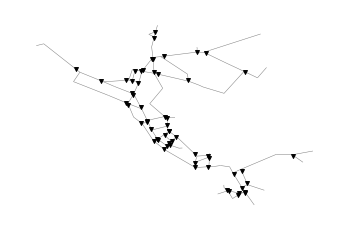

In [6]:
# Graph valve layer
wntr.graphics.plot_valve_layer(wn, valve_layer, add_colorbar=False, include_network=True)

<AxesSubplot:>

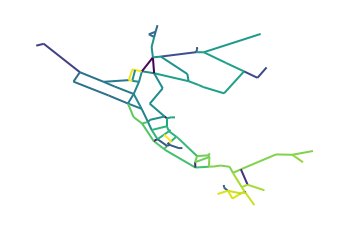

In [7]:
# Graph segments within network
wntr.graphics.plot_network(wn, link_attribute=link_segments, link_cmap = cmap, node_size=0, link_width=2, add_colorbar= False)

### 3 Simulate hydraulics

A try/except/finally approach is taken to ensure the script can finish running and still catch any convergence issues that might have occurred due to a segment break. A user can revisit nodes with failed simulations individually to determine the cause of failure, if desired. 

In [8]:
# Create dictionary to save results
analysis_results = {}

# Simulate segment break (simulated as multiple pipe closures) for each segment
for segment in link_segments.unique():
    wn = wntr.network.WaterNetworkModel(inp_file)
    wn.options.hydraulic.demand_model = 'PDD'    
    wn.options.time.duration = total_duration
    wn.options.hydraulic.minimum_pressure = minimum_pressure
    wn.options.hydraulic.required_pressure = required_pressure

    # Identify pipes within the segment
    pipes_in_seg = link_segments[link_segments == segment]
    
    for pipe_name in pipes_in_seg.index:
        # Create pipe closure control and apply to pipe of interest
        pipe = wn.get_link(pipe_name) 
        act = wntr.network.controls.ControlAction(pipe, 'status', 0)
        cond = wntr.network.controls.SimTimeCondition(wn, 'Above', start_time)
        ctrl = wntr.network.controls.Control(cond, act)
        wn.add_control('close pipe ' + pipe_name, ctrl)
        
    try:
        # Simulate hydraulics
        sim = wntr.sim.WNTRSimulator(wn)
        sim_results = sim.run_sim()
 
        # Using pressure results, identify impacted junctions
        sim_pressure = sim_results.node['pressure'].loc[start_time::, nzd_junct]
        sim_pressure_below_pmin = sim_pressure.columns[(sim_pressure < minimum_pressure).any()]
        impacted_junctions = set(sim_pressure_below_pmin) - set(normal_pressure_below_pmin)
        
    except Exception as e:
        # Identify failed simulations and the reason
        impacted_junctions = None
        print(segment, ' Failed:', e)

    finally:
        # Save simulation results
        analysis_results[segment] = impacted_junctions

### 4 Visualize results

#### 4a Calculate junction and population impacts
The impacts for each segment are calculated and then mapped to each pipe within that segment. This allows for the impacts to be plotted onto a network map correctly. 

In [9]:
# Calculate population per junction
population = wntr.metrics.population(wn)

# Save junction and population impact results to dictionary
num_junctions_impacted_per_segment = {}
num_people_impacted_per_segment = {}
for segment, impacted_junctions in analysis_results.items():
    if impacted_junctions is not None:
        num_junctions_impacted_per_segment[segment] = len(impacted_junctions)
        num_people_impacted_per_segment[segment] = population[impacted_junctions].sum()

# Map segment junction and population impacts to each pipe within the segment
num_junctions_impacted = link_segments.map(num_junctions_impacted_per_segment)
num_people_impacted = link_segments.map(num_people_impacted_per_segment)

#### 4b Plot results
If a different INP file from the example Net3.inp file is being used, the parameter node_range can be adjusted to better suit the simulation results.

<AxesSubplot:title={'center':'Number of people impacted by each segment closure'}>

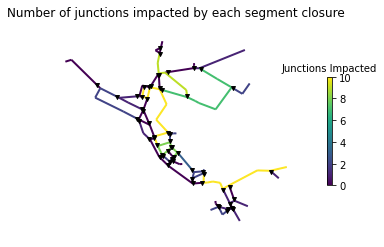

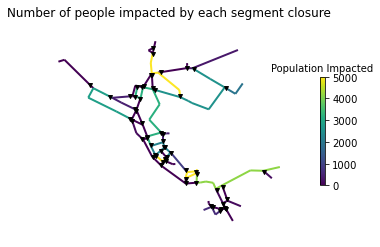

In [10]:
#Plot junctions impacted due to segment breaks
wntr.graphics.plot_network(wn, link_attribute=num_junctions_impacted, node_size=0, link_width=2, 
                           link_range=[0,10], link_cmap = cmap, link_colorbar_label='Junctions Impacted', 
                           title='Number of junctions impacted by each segment closure')
# Extracts current axes
ax = plt.gca()
# Graphs valve layer onto the same axes
wntr.graphics.plot_valve_layer(wn, valve_layer, add_colorbar=False, include_network=False, ax=ax)

#Plot population impacted due to segment breaks
wntr.graphics.plot_network(wn, link_attribute=num_people_impacted, node_size=0, link_width=2, 
                           link_range=[0,5000], link_cmap = cmap, link_colorbar_label='Population Impacted', 
                           title='Number of people impacted by each segment closure')
# Extracts current axes
ax = plt.gca()
# Graphs valve layer onto the same axes
wntr.graphics.plot_valve_layer(wn, valve_layer, add_colorbar=False, include_network=False, ax=ax)

#### Data Testing
The following code is included for data testing and is not required for segment break analysis.

In [12]:
import pandas as pd

# Test simulation results
# Import expected results
junct_test = pd.read_csv('../../wntr/tests/data_for_testing/segment_break_demo_junction_test_data.csv', index_col = 0, squeeze = True)
people_test = pd.read_csv('../../wntr/tests/data_for_testing/segment_break_demo_people_test_data.csv', index_col = 0, squeeze = True)

# Check if simulation results match expected results
num_junctions_impacted.index = num_junctions_impacted.index.astype('int64')
num_people_impacted.index = num_people_impacted.index.astype('int64')

assert (junct_test == num_junctions_impacted).all(axis=None) == True, "impacted junction results differ"
assert (people_test == num_people_impacted).all(axis=None)  == True, "impacted people results differ"